In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers.recurrent import LSTM
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('train.csv', sep='\t')
test_df = pd.read_csv('test.csv', sep='\t')
sample_submission_df = pd.read_csv('sample_submission.csv')

In [3]:
x_train = train_df.drop(columns = ['label'])
print(x_train)
y_train = train_df['label']
y_train = y_train.replace('label', 0, regex=True)

x_test = test_df.drop(columns = ['id'])
y_test = sample_submission_df['label']
y_true = y_test

                                                   text
0     Get the latest from TODAY Sign up for our news...
1     2d  Conan On The Funeral Trump Will Be Invited...
2     It’s safe to say that Instagram Stories has fa...
3     Much like a certain Amazon goddess with a lass...
4     At a time when the perfect outfit is just one ...
...                                                 ...
4982  The storybook romance of WWE stars John Cena a...
4983  The actor told friends he’s responsible for en...
4984  Sarah Hyland is getting real.  The Modern Fami...
4985  Production has been suspended on the sixth and...
4986  A jury ruled against Bill Cosby in his sexual ...

[4987 rows x 1 columns]


In [4]:
# 建立Token
token = Tokenizer(num_words=3800) #使用Tokenizer模組建立token，建立一個3800字的字典
#讀取所有訓練資料影評，依照每個英文字在訓練資料出現的次數進行排序，前3800名的英文單字會加進字典中
token.fit_on_texts(x_train['text']) 
print(token.word_index) #可以看到它將英文字轉為數字的結果，例如:the轉換成1
#透過texts_to_sequences可以將訓練和測試集資料中的影評文字轉換為數字list
x_train_seq = token.texts_to_sequences(x_train['text'])
x_test_seq = token.texts_to_sequences(x_test['text']) 
print(x_train_seq)
print(x_test_seq)

{'the': 1, 'and': 2, 'to': 3, 'a': 4, 'of': 5, 'in': 6, 'that': 7, 'on': 8, 'for': 9, 'her': 10, 'was': 11, 'with': 12, 'is': 13, 'she': 14, 'i': 15, 'it': 16, 'as': 17, 'at': 18, 'he': 19, 'his': 20, '”': 21, 'you': 22, 'have': 23, 'be': 24, 'this': 25, 'by': 26, 'from': 27, 'but': 28, 'has': 29, 'an': 30, 'not': 31, 'their': 32, 'are': 33, 'they': 34, 'about': 35, 'we': 36, 'who': 37, 'said': 38, 'had': 39, 'after': 40, 'up': 41, 'one': 42, 'all': 43, 'so': 44, 'out': 45, 'when': 46, 'been': 47, 'new': 48, 'will': 49, 'were': 50, 'time': 51, 'also': 52, 'my': 53, 'more': 54, 'which': 55, 'first': 56, '—': 57, 'just': 58, 'like': 59, 'or': 60, 'what': 61, 'people': 62, 'year': 63, 'would': 64, 'me': 65, 'him': 66, 'two': 67, 'show': 68, 'if': 69, 'do': 70, 'now': 71, 'no': 72, 'get': 73, 'there': 74, 'our': 75, 'years': 76, 'can': 77, 'over': 78, '2017': 79, 'know': 80, 'your': 81, 'because': 82, 'while': 83, 'other': 84, 'back': 85, 'some': 86, 'us': 87, 'them': 88, 'into': 89, 'love

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
# 每一篇影評文字字數不固定，但後續進行深度學習模型訓練時長度必須固定
# 截長補短
x_train = sequence.pad_sequences(x_train_seq, maxlen=380)
x_test = sequence.pad_sequences(x_test_seq, maxlen=380)
#長度小於380的，前面的數字補0 #長度大於380的，截去前面的數字
#變成25000*380的矩陣 = 25000則評論，每則包含380個數字
print(x_train)
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
print(x_train)

[[   0    0    0 ... 1008    8  202]
 [   0    0    0 ... 1449    3    8]
 [ 134 2353    6 ...    2  528  699]
 ...
 [   0    0    0 ...  535  391 1791]
 [   0    0    0 ...    1 1022  503]
 [  18  933    5 ...    8 1368  215]]
[[0.000e+00 0.000e+00 0.000e+00 ... 1.008e+03 8.000e+00 2.020e+02]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.449e+03 3.000e+00 8.000e+00]
 [1.340e+02 2.353e+03 6.000e+00 ... 2.000e+00 5.280e+02 6.990e+02]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 5.350e+02 3.910e+02 1.791e+03]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.000e+00 1.022e+03 5.030e+02]
 [1.800e+01 9.330e+02 5.000e+00 ... 8.000e+00 1.368e+03 2.150e+02]]


RNN

In [6]:
modelRNN = Sequential()
modelRNN.add(Embedding(output_dim=32, #輸出的維度是32，希望將數字list轉換為32維度的向量
                        input_dim=3800, #輸入的維度是3800，也就是我們之前建立的字典是3800字 
                        input_length=380)) #數字list截長補短後都是380個數字


# 建立RNN層，建立16個神經元的RNN層
modelRNN.add(SimpleRNN(units=16))
# 建立隱藏層，建立256個神經元的隱藏層，ReLU激活函數
modelRNN.add(Dense(units=256,activation='relu'))
#隨機在神經網路中放棄70%的神經元，避免overfitting
modelRNN.add(Dropout(0.7)) 
# 建立輸出層，Sigmoid激活函數
modelRNN.add(Dense(units=1,activation='sigmoid')) #建立一個神經元的輸出層
modelRNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 380, 32)           121600    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 16)                784       
_________________________________________________________________
dense (Dense)                (None, 256)               4352      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 126,993
Trainable params: 126,993
Non-trainable params: 0
_________________________________________________________________


In [7]:
# 定義訓練模型
modelRNN.compile(loss='binary_crossentropy',
                 optimizer='adam', 
                 metrics=['accuracy'])

In [8]:
#Loss function使用Cross entropy 
#adam最優化方法可以更快收斂
train_history = modelRNN.fit(x_train,
                             y_train, 
                             epochs=10,
                             batch_size=100, 
                             verbose=2, 
                             validation_split=0.2)

Epoch 1/10
40/40 - 2s - loss: 0.6819 - accuracy: 0.5723 - val_loss: 0.6731 - val_accuracy: 0.5922
Epoch 2/10
40/40 - 2s - loss: 0.6462 - accuracy: 0.6144 - val_loss: 0.6623 - val_accuracy: 0.6263
Epoch 3/10
40/40 - 2s - loss: 0.5197 - accuracy: 0.7566 - val_loss: 0.7228 - val_accuracy: 0.5691
Epoch 4/10
40/40 - 2s - loss: 0.2621 - accuracy: 0.9153 - val_loss: 0.9258 - val_accuracy: 0.5812
Epoch 5/10
40/40 - 2s - loss: 0.1107 - accuracy: 0.9677 - val_loss: 1.1548 - val_accuracy: 0.5842
Epoch 6/10
40/40 - 2s - loss: 0.0547 - accuracy: 0.9860 - val_loss: 1.3442 - val_accuracy: 0.5832
Epoch 7/10
40/40 - 2s - loss: 0.0403 - accuracy: 0.9887 - val_loss: 1.5217 - val_accuracy: 0.5762
Epoch 8/10
40/40 - 2s - loss: 0.0357 - accuracy: 0.9892 - val_loss: 1.5367 - val_accuracy: 0.5651
Epoch 9/10
40/40 - 2s - loss: 0.0300 - accuracy: 0.9922 - val_loss: 1.5613 - val_accuracy: 0.5822
Epoch 10/10
40/40 - 2s - loss: 0.0229 - accuracy: 0.9940 - val_loss: 1.5649 - val_accuracy: 0.5892


In [9]:
scores = modelRNN.evaluate(x_test, y_true,verbose=1)
print(scores[1])

39/39 [==============================] - 0s 8ms/step - loss: 2.1632 - accuracy: 0.4916
0.4915798008441925


In [10]:
def show_train_history(train, val, accuracy_or_loss):
    # accuracy_or_loss : input 'Accuracy' or 'loss'
    plt.figure()
    plt.plot(train_history.history[train]) 
    plt.plot(train_history.history[val])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel(accuracy_or_loss)
    plt.legend(["train", "validation"], loc="upper left") 
    plt.show()

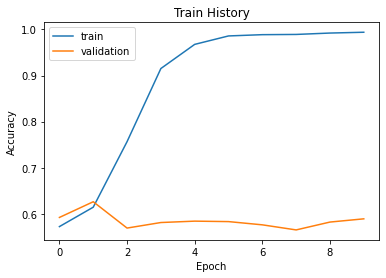

In [11]:
show_train_history('accuracy', 'val_accuracy', 'Accuracy')

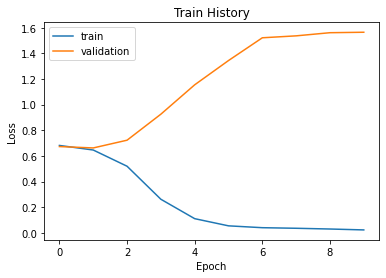

In [12]:
show_train_history('loss', 'val_loss', 'Loss')

LSTM

In [13]:
modelLSTM = Sequential() #建立模型
modelLSTM .add(Embedding(output_dim=32, #輸出的維度是32，希望將數字list轉換為32維度的向量
                         input_dim=3800, #輸入的維度是3800，也就是我們之前建立的字典是3800字
                         input_length=380)) #數字list截長補短後都是380個數字

# 建立LSTM層 
modelLSTM .add(LSTM(32)) #建立32個神經元的LSTM層
# 建立隱藏層
modelLSTM .add(Dense(units=256,activation='relu')) #建立256個神經元的隱藏層
modelLSTM .add(Dropout(0.7))
# 建立輸出層，建立一個神經元的輸出層
modelLSTM .add(Dense(units=1,activation='sigmoid'))
# 查看模型摘要
modelLSTM .summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 380, 32)           121600    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 138,625
Trainable params: 138,625
Non-trainable params: 0
_________________________________________________________________


In [14]:
modelLSTM.compile(loss='binary_crossentropy',
                 optimizer='adam', 
                 metrics=['accuracy'])
#Loss function使用Cross entropy 
#adam最優化方法可以更快收斂
train_history = modelLSTM.fit(x_train,
                             y_train, 
                             epochs=10,
                             batch_size=100, 
                             verbose=2, 
                             validation_split=0.2)

Epoch 1/10
40/40 - 5s - loss: 0.6801 - accuracy: 0.5966 - val_loss: 0.6724 - val_accuracy: 0.5922
Epoch 2/10
40/40 - 5s - loss: 0.6416 - accuracy: 0.6285 - val_loss: 0.6318 - val_accuracy: 0.6293
Epoch 3/10
40/40 - 5s - loss: 0.4936 - accuracy: 0.7776 - val_loss: 0.6218 - val_accuracy: 0.6834
Epoch 4/10
40/40 - 5s - loss: 0.3466 - accuracy: 0.8549 - val_loss: 0.7430 - val_accuracy: 0.6603
Epoch 5/10
40/40 - 5s - loss: 0.2620 - accuracy: 0.8987 - val_loss: 0.8358 - val_accuracy: 0.6914
Epoch 6/10
40/40 - 5s - loss: 0.1910 - accuracy: 0.9323 - val_loss: 1.0642 - val_accuracy: 0.6493
Epoch 7/10
40/40 - 5s - loss: 0.1189 - accuracy: 0.9584 - val_loss: 1.1790 - val_accuracy: 0.6673
Epoch 8/10
40/40 - 5s - loss: 0.0819 - accuracy: 0.9742 - val_loss: 1.5168 - val_accuracy: 0.6463
Epoch 9/10
40/40 - 5s - loss: 0.0604 - accuracy: 0.9830 - val_loss: 1.6410 - val_accuracy: 0.6493
Epoch 10/10
40/40 - 5s - loss: 0.0494 - accuracy: 0.9875 - val_loss: 1.7623 - val_accuracy: 0.6533


In [15]:
scores = modelLSTM.evaluate(x_test, y_true, verbose=1)
print(scores[1])

39/39 [==============================] - 1s 14ms/step - loss: 3.0547 - accuracy: 0.4852
0.4851644039154053


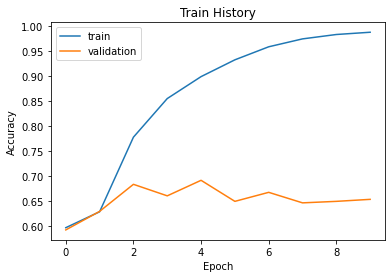

In [16]:
show_train_history('accuracy', 'val_accuracy', 'Accuracy')

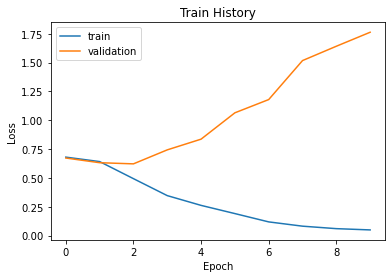

In [17]:
show_train_history('loss', 'val_loss', 'Loss')